<a href="https://colab.research.google.com/github/gautamHCSCV/Chest-Image-classification/blob/main/Chest_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Chest image classification

Importing necessary libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Layer
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import pickle
with open("/content/drive/MyDrive/lungs_image_classification/data.pkl",'rb') as file:
  dataset = pickle.load(file)

In [ ]:
x = dataset['xtrain'][:1200]/255.0
x.shape

(1200, 224, 224, 3)

In [ ]:
y = dataset['ytrain'][:1200]
y.shape

(1200,)

In [ ]:
from collections import Counter
Counter(y)

Counter({0: 534, 1: 666})

In [ ]:
x_test = x[1000:]
y_test = y[1000:]

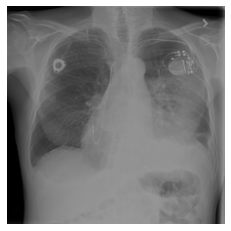

1


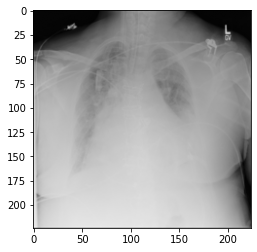

0


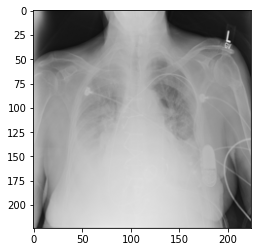

1


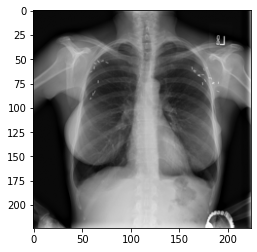

0


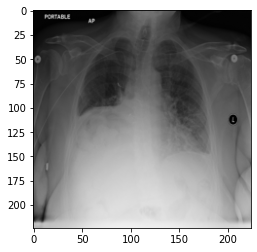

0


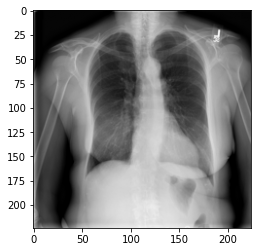

1


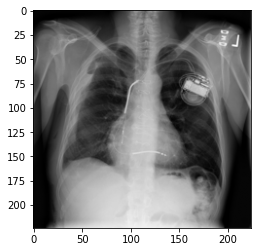

1


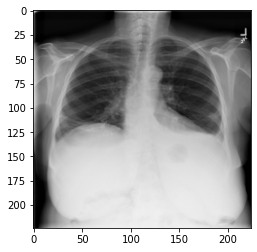

1


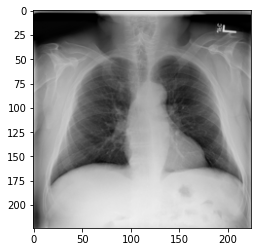

1


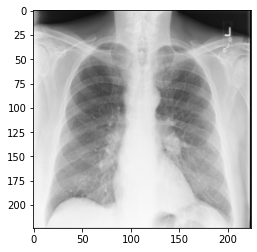

1


In [ ]:
plt.axis('off')
for i in range(10,20):
    plt.imshow(x_train[i])
    plt.show()
    print(y_train[i])

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x[:1000],y[:1000], test_size = 0.2)

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(16)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(16)
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(16)
train_dataset.element_spec

(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float64, name=None),
 TensorSpec(shape=(None,), dtype=tf.int64, name=None))

**ResNet Model**

In [ ]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Add, MaxPooling2D, GlobalAveragePooling2D, Layer, Dense, Dropout, Input, Flatten
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import regularizers

In [ ]:
class ResidualBlock(Layer):

    def __init__(self, **kwargs):
        super(ResidualBlock, self).__init__(**kwargs)
        
    def build(self, input_shape):
        
        self.bn1 = tf.keras.layers.BatchNormalization(input_shape = input_shape)
        self.conv1 = tf.keras.layers.Conv2D(input_shape[-1], kernel_size= (3,3), padding= 'same')
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.conv2 = tf.keras.layers.Conv2D(input_shape[-1], kernel_size= (3,3), padding= 'same')
        
    def call(self, inputs, training=False):
        
        x = self.bn1(inputs, training = training)
        x = tf.nn.relu(x)
        x = self.conv1(x)
        
        x = self.bn2(x, training = training)
        x = tf.nn.relu(x)
        x = self.conv2(x)
        return(x)

In [ ]:
test_model = tf.keras.Sequential([ResidualBlock(input_shape=(28, 28, 3), name="residual_block")])
test_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
residual_block (ResidualBloc (None, 28, 28, 1)         28        
Total params: 28
Trainable params: 24
Non-trainable params: 4
_________________________________________________________________


In [ ]:
class FiltersChangeResidualBlock(Layer):

    def __init__(self, out_filters, **kwargs):
        
        super(FiltersChangeResidualBlock, self).__init__(**kwargs)
        self.out_filters = out_filters
        
    def build(self, input_shape):
        
        self.bn1 = tf.keras.layers.BatchNormalization(input_shape = input_shape)
        self.conv1 = tf.keras.layers.Conv2D(input_shape[-1], kernel_size= (3,3), padding= 'same')
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.conv2 = tf.keras.layers.Conv2D(self.out_filters, kernel_size= (3,3), padding= 'same')
        self.conv3 = tf.keras.layers.Conv2D(self.out_filters, kernel_size = (1,1))
        
    def call(self, inputs, training=False):
        
        x = self.bn1(inputs, training = training)
        x = tf.nn.relu(x)
        x = self.conv1(x)
        
        x = self.bn2(x, training = training)
        x = tf.nn.relu(x)
        x = self.conv2(x)
        x = self.conv3(x)
        return(x)

In [ ]:
test_model = tf.keras.Sequential([FiltersChangeResidualBlock(16, input_shape=(32, 32, 3), name="fc_resnet_block")])
test_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
fc_resnet_block (FiltersChan (None, 32, 32, 16)        450       
Total params: 450
Trainable params: 446
Non-trainable params: 4
_________________________________________________________________


In [ ]:
from tensorflow.keras.models import Model
class ResNetModel(Model):

    def __init__(self, **kwargs):
        super(ResNetModel, self).__init__(**kwargs)
        self.conv1 = tf.keras.layers.Conv2D(32, kernel_size= (7,7), strides=2)
        self.residual = ResidualBlock() 
        self.conv2 = tf.keras.layers.Conv2D(32, kernel_size=(3,3), strides=2)
        self.fcrb = FiltersChangeResidualBlock(64)
        self.flatten = tf.keras.layers.Flatten()
        self.dense = tf.keras.layers.Dense(1, activation = 'sigmoid')
        
    def call(self, inputs, training=False):

        x = self.conv1(inputs)
        x = self.residual(x, training = training)
        x = self.conv2(x)
        x = self.fcrb(x, training = training)
        x = self.flatten(x)
        x = self.dense(x)
        return(x)

In [ ]:
# input shape of resnet model is (28,28,1) or (28,28,3) for rgb channels
resnet_model = ResNetModel()

In [ ]:
resnet_model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
his = resnet_model.fit(train_dataset, validation_data=val_dataset, epochs = 16)

Epoch 1/16
50/50 [==============================] - 73s 1s/step - loss: 2.4623 - accuracy: 0.5450 - val_loss: 0.7861 - val_accuracy: 0.4700
Epoch 2/16
50/50 [==============================] - 76s 2s/step - loss: 0.7298 - accuracy: 0.6662 - val_loss: 0.7217 - val_accuracy: 0.5300
Epoch 3/16
50/50 [==============================] - 72s 1s/step - loss: 0.4873 - accuracy: 0.7675 - val_loss: 1.0749 - val_accuracy: 0.5600
Epoch 4/16
50/50 [==============================] - 72s 1s/step - loss: 0.4639 - accuracy: 0.8012 - val_loss: 1.2363 - val_accuracy: 0.5450
Epoch 5/16
50/50 [==============================] - 72s 1s/step - loss: 0.6411 - accuracy: 0.7875 - val_loss: 1.9073 - val_accuracy: 0.5300
Epoch 6/16
50/50 [==============================] - 73s 1s/step - loss: 0.8345 - accuracy: 0.8025 - val_loss: 3.6273 - val_accuracy: 0.5500
Epoch 7/16
50/50 [==============================] - 72s 1s/step - loss: 1.6628 - accuracy: 0.7588 - val_loss: 3.2553 - val_accuracy: 0.5150
Epoch 8/16
50/50 [==

In [ ]:
_ , acc = resnet_model.evaluate(test_dataset)
acc

13/13 [==============================] - 4s 316ms/step - loss: 3.5029 - accuracy: 0.5100


0.5099999904632568

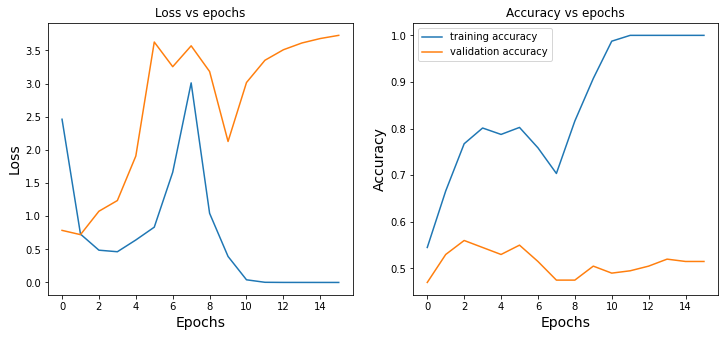

In [ ]:
# showing training results
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(12, 5))

axes[0].set_xlabel("Epochs", fontsize=14)
axes[0].set_ylabel("Loss", fontsize=14)
axes[0].set_title('Loss vs epochs')
axes[0].plot(his.history['loss'], label = 'training loss')
axes[0].plot(his.history['val_loss'], label = 'validation loss')

axes[1].set_title('Accuracy vs epochs')
axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epochs", fontsize=14)
axes[1].plot(his.history['accuracy'], label = 'training accuracy')
axes[1].plot(his.history['val_accuracy'], label = 'validation accuracy')
plt.legend()
plt.show()

**New architecture model with less trainable parameters**

In [ ]:
data_augmentation = Sequential([
                                tf.keras.layers.experimental.preprocessing.RandomContrast(0.9),
                                tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
                                tf.keras.layers.experimental.preprocessing.RandomFlip(mode = 'horizontal')
])

In [ ]:
inp = Input(shape = (224,224,3))
x = data_augmentation(inp)
x = BatchNormalization()(x)
x = Conv2D(16, kernel_size=(3,3), padding = 'same')(x)
x = MaxPooling2D(pool_size=(3,3))(x)
x = BatchNormalization()(x)
x = Conv2D(32, kernel_size=(3,3), padding = 'same')(x)
x = MaxPooling2D(pool_size=(3,3))(x)
x = BatchNormalization()(x)
x = Conv2D(64, kernel_size=(3,3))(x)
x = MaxPooling2D(pool_size=(3,3))(x)
x = Flatten()(x)
x = Dense(32, activation='relu')(x)
out = Dense(1, activation='sigmoid')(x)

model = Model(inputs = inp, outputs = out)

In [ ]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 224, 224, 3)       12        
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 74, 74, 16)        0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 74, 74, 16)        64        
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 74, 74, 32)        4640

In [ ]:
model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
def scheduler(epoch, lr):
  if epoch < 10:
    return lr
  elif epoch % 5 ==0:
    return lr * tf.math.exp(-0.1)
  else:
    return lr

lrs = tf.keras.callbacks.LearningRateScheduler(scheduler)
early_stop = tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_accuracy', restore_best_weights=True)
his = model.fit(train_dataset, validation_data=val_dataset, epochs = 32, verbose = 1, callbacks = [lrs])

Epoch 1/32
50/50 [==============================] - 38s 734ms/step - loss: 0.7841 - accuracy: 0.5813 - val_loss: 0.6931 - val_accuracy: 0.5250
Epoch 2/32
50/50 [==============================] - 36s 730ms/step - loss: 0.6955 - accuracy: 0.5888 - val_loss: 0.6908 - val_accuracy: 0.5250
Epoch 3/32
50/50 [==============================] - 37s 734ms/step - loss: 0.6813 - accuracy: 0.5850 - val_loss: 0.6839 - val_accuracy: 0.5250
Epoch 4/32
50/50 [==============================] - 36s 730ms/step - loss: 0.6617 - accuracy: 0.5838 - val_loss: 0.6828 - val_accuracy: 0.5250
Epoch 5/32
50/50 [==============================] - 36s 731ms/step - loss: 0.6555 - accuracy: 0.5888 - val_loss: 0.6782 - val_accuracy: 0.5250
Epoch 6/32
50/50 [==============================] - 37s 731ms/step - loss: 0.6617 - accuracy: 0.5938 - val_loss: 0.6759 - val_accuracy: 0.5700
Epoch 7/32
50/50 [==============================] - 37s 733ms/step - loss: 0.6553 - accuracy: 0.6025 - val_loss: 0.6718 - val_accuracy: 0.6100

In [ ]:
model.evaluate(test_dataset)

13/13 [==============================] - 2s 177ms/step - loss: 0.7691 - accuracy: 0.5350


[0.7691020965576172, 0.5350000262260437]

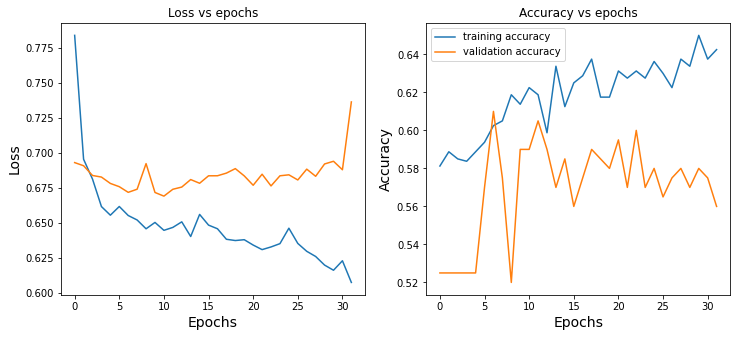

In [ ]:
# showing training results
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(12, 5))

axes[0].set_xlabel("Epochs", fontsize=14)
axes[0].set_ylabel("Loss", fontsize=14)
axes[0].set_title('Loss vs epochs')
axes[0].plot(his.history['loss'], label = 'training loss')
axes[0].plot(his.history['val_loss'], label = 'validation loss')

axes[1].set_title('Accuracy vs epochs')
axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epochs", fontsize=14)
axes[1].plot(his.history['accuracy'], label = 'training accuracy')
axes[1].plot(his.history['val_accuracy'], label = 'validation accuracy')
plt.legend()
plt.show()

**Resnet model with Skip connections**

In [ ]:
class IdentityBlock(Layer):
    def __init__(self, **kwargs):
        super(IdentityBlock, self).__init__(**kwargs)

    def build(self, input_shape): 
        self.conv1 = Conv2D(input_shape[-1], kernel_size=(3,3), padding='same')
        self.conv2 = Conv2D(input_shape[-1], kernel_size=(3,3), padding='same')
        self.bn1 = BatchNormalization()
        self.bn2 = BatchNormalization()
        self.act = Activation('relu')
        self.add = Add()

    def call(self, inputs):

        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.act(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.act(x)
        x = self.add([x, inputs])
        x = self.act(x)
        return x

In [ ]:
test_model = Sequential([IdentityBlock(input_shape = (16, 28, 28,3))])
test_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
identity_block_9 (IdentityBl (None, 16, 28, 28, 3)     192       
Total params: 192
Trainable params: 180
Non-trainable params: 12
_________________________________________________________________


In [ ]:
class Resnet(Model):
    def __init__(self):
        
        super(Resnet, self).__init__()
        self.ida1 = IdentityBlock()
        self.ida2 = IdentityBlock()
        self.conv1 = Conv2D(16, kernel_size=(3,3))
        
        self.bn = BatchNormalization()
        self.act = Activation('relu')
        self.max_pool = MaxPooling2D(pool_size=(3,3))
        self.global_pool = GlobalAveragePooling2D()
        self.dense2 = Dense(1, activation = 'sigmoid')

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.bn(x)
        x = self.act(x)
        x = self.max_pool(x)
        x = self.ida1(x)
        x = self.ida2(x)
        x = self.global_pool(x)
        x = self.dense2(x)
        return x

In [ ]:
model = Resnet()
model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

def scheduler(epoch, lr):
  if epoch < 10:
    return lr
  elif epoch % 5 ==0:
    return lr * tf.math.exp(-0.1)
  else:
    return lr

lrs = tf.keras.callbacks.LearningRateScheduler(scheduler)
early_stop = tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_accuracy', restore_best_weights=True)
his = model.fit(train_dataset, validation_data=val_dataset, epochs = 100, verbose = 1, callbacks = [lrs, early_stop])

Epoch 1/100
50/50 [==============================] - 41s 808ms/step - loss: 1.0591 - accuracy: 0.4325 - val_loss: 0.6833 - val_accuracy: 0.6050
Epoch 2/100
50/50 [==============================] - 40s 803ms/step - loss: 0.7179 - accuracy: 0.4925 - val_loss: 0.6782 - val_accuracy: 0.6050
Epoch 3/100
50/50 [==============================] - 40s 804ms/step - loss: 0.6831 - accuracy: 0.5537 - val_loss: 0.6842 - val_accuracy: 0.6050
Epoch 4/100
50/50 [==============================] - 40s 804ms/step - loss: 0.6778 - accuracy: 0.5713 - val_loss: 0.6886 - val_accuracy: 0.6050
Epoch 5/100
50/50 [==============================] - 40s 804ms/step - loss: 0.6754 - accuracy: 0.5875 - val_loss: 0.6960 - val_accuracy: 0.6050
Epoch 6/100
50/50 [==============================] - 40s 803ms/step - loss: 0.6740 - accuracy: 0.5875 - val_loss: 0.6810 - val_accuracy: 0.6050
Epoch 7/100
50/50 [==============================] - 40s 802ms/step - loss: 0.6728 - accuracy: 0.5913 - val_loss: 0.6909 - val_accuracy:

In [ ]:
model.evaluate(test_dataset)

13/13 [==============================] - 3s 202ms/step - loss: 0.6998 - accuracy: 0.5100


[0.6998201608657837, 0.5099999904632568]

In [ ]:
round(model.optimizer.lr.numpy(), 5)

0.00074

In [ ]:
model.summary()

Model: "resnet_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
identity_block_14 (IdentityB multiple                  4768      
_________________________________________________________________
identity_block_15 (IdentityB multiple                  4768      
_________________________________________________________________
conv2d_8 (Conv2D)            multiple                  448       
_________________________________________________________________
batch_normalization_6 (Batch multiple                  64        
_________________________________________________________________
activation_6 (Activation)    multiple                  0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 multiple                  0         
_________________________________________________________________
global_average_pooling2d_6 ( multiple                  0  

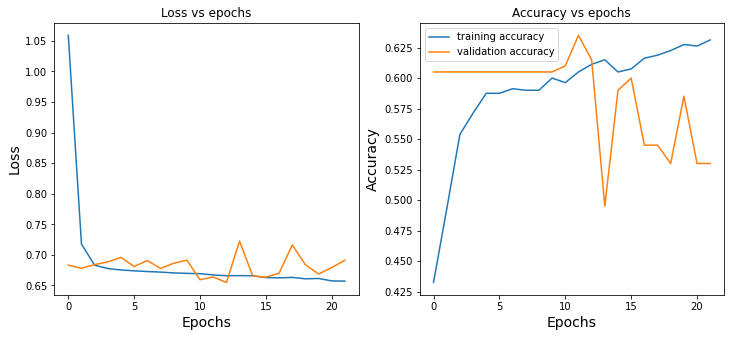

In [ ]:
# showing training results
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(12, 5))

axes[0].set_xlabel("Epochs", fontsize=14)
axes[0].set_ylabel("Loss", fontsize=14)
axes[0].set_title('Loss vs epochs')
axes[0].plot(his.history['loss'], label = 'training loss')
axes[0].plot(his.history['val_loss'], label = 'validation loss')

axes[1].set_title('Accuracy vs epochs')
axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epochs", fontsize=14)
axes[1].plot(his.history['accuracy'], label = 'training accuracy')
axes[1].plot(his.history['val_accuracy'], label = 'validation accuracy')
plt.legend()
plt.show()

**Mobile Net V2 model**

In [ ]:
import tensorflow_hub as hub
model = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4",
                   trainable=False),  
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.build([None, 224, 224, 3])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
his = model.fit(train_dataset, validation_data=val_dataset, epochs = 20, callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_accuracy', 
                                                                                                                    restore_best_weights = True)])

Epoch 1/20
50/50 [==============================] - 30s 527ms/step - loss: 0.7270 - accuracy: 0.5550 - val_loss: 0.6597 - val_accuracy: 0.6550
Epoch 2/20
50/50 [==============================] - 27s 544ms/step - loss: 0.6439 - accuracy: 0.6263 - val_loss: 0.6534 - val_accuracy: 0.6650
Epoch 3/20
50/50 [==============================] - 27s 544ms/step - loss: 0.6204 - accuracy: 0.6525 - val_loss: 0.6496 - val_accuracy: 0.6700
Epoch 4/20
50/50 [==============================] - 27s 544ms/step - loss: 0.6006 - accuracy: 0.6750 - val_loss: 0.6473 - val_accuracy: 0.6750
Epoch 5/20
50/50 [==============================] - 27s 548ms/step - loss: 0.5834 - accuracy: 0.6888 - val_loss: 0.6456 - val_accuracy: 0.6650
Epoch 6/20
50/50 [==============================] - 27s 547ms/step - loss: 0.5681 - accuracy: 0.6988 - val_loss: 0.6446 - val_accuracy: 0.6700
Epoch 7/20
50/50 [==============================] - 27s 547ms/step - loss: 0.5542 - accuracy: 0.7150 - val_loss: 0.6441 - val_accuracy: 0.6750

In [ ]:
model.evaluate(test_dataset)

13/13 [==============================] - 6s 445ms/step - loss: 0.7495 - accuracy: 0.5150


[0.7495056390762329, 0.5149999856948853]

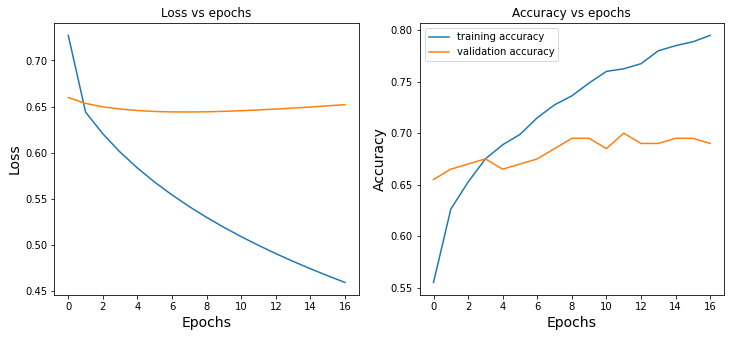

In [ ]:
# showing training results
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(12, 5))

axes[0].set_xlabel("Epochs", fontsize=14)
axes[0].set_ylabel("Loss", fontsize=14)
axes[0].set_title('Loss vs epochs')
axes[0].plot(his.history['loss'], label = 'training loss')
axes[0].plot(his.history['val_loss'], label = 'validation loss')

axes[1].set_title('Accuracy vs epochs')
axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epochs", fontsize=14)
axes[1].plot(his.history['accuracy'], label = 'training accuracy')
axes[1].plot(his.history['val_accuracy'], label = 'validation accuracy')
plt.legend()
plt.show()

**Mobile net V2 with trainable top**

In [ ]:
import tensorflow_hub as hub
model = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4",
                   trainable=True),  
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.build([None, 224, 224, 3])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_2 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 2,225,153
Non-trainable params: 34,112
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
his = model.fit(train_dataset, validation_data=val_dataset, epochs = 20, callbacks=[tf.keras.callbacks.EarlyStopping(patience=4, monitor='val_accuracy', 
                                                                                                                    restore_best_weights = True)])

Epoch 1/20
50/50 [==============================] - 148s 3s/step - loss: 0.8589 - accuracy: 0.5650 - val_loss: 1.3120 - val_accuracy: 0.4200
Epoch 2/20
50/50 [==============================] - 142s 3s/step - loss: 0.6229 - accuracy: 0.7287 - val_loss: 1.1052 - val_accuracy: 0.4150
Epoch 3/20
50/50 [==============================] - 141s 3s/step - loss: 0.5430 - accuracy: 0.7825 - val_loss: 1.4231 - val_accuracy: 0.4400
Epoch 4/20
50/50 [==============================] - 140s 3s/step - loss: 0.5993 - accuracy: 0.7588 - val_loss: 1.1268 - val_accuracy: 0.4900
Epoch 5/20
50/50 [==============================] - 140s 3s/step - loss: 0.4145 - accuracy: 0.8587 - val_loss: 1.5939 - val_accuracy: 0.5800
Epoch 6/20
50/50 [==============================] - 139s 3s/step - loss: 0.4731 - accuracy: 0.8225 - val_loss: 1.4616 - val_accuracy: 0.5600
Epoch 7/20
50/50 [==============================] - 140s 3s/step - loss: 0.3637 - accuracy: 0.8850 - val_loss: 1.9542 - val_accuracy: 0.5500
Epoch 8/20
50

In [ ]:
model.evaluate(test_dataset)

13/13 [==============================] - 5s 359ms/step - loss: 2.0027 - accuracy: 0.4900


[2.002673387527466, 0.49000000953674316]

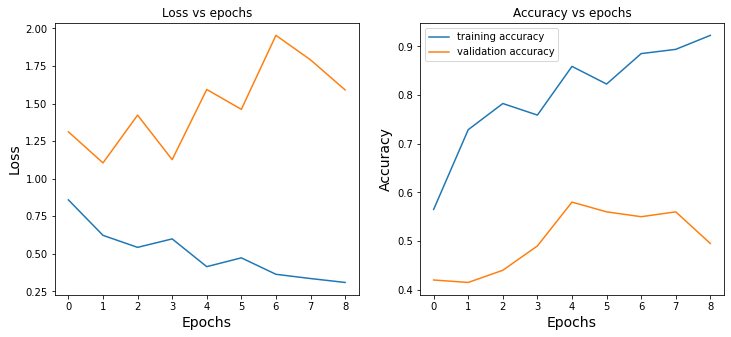

In [ ]:
# showing training results
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(12, 5))

axes[0].set_xlabel("Epochs", fontsize=14)
axes[0].set_ylabel("Loss", fontsize=14)
axes[0].set_title('Loss vs epochs')
axes[0].plot(his.history['loss'], label = 'training loss')
axes[0].plot(his.history['val_loss'], label = 'validation loss')

axes[1].set_title('Accuracy vs epochs')
axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epochs", fontsize=14)
axes[1].plot(his.history['accuracy'], label = 'training accuracy')
axes[1].plot(his.history['val_accuracy'], label = 'validation accuracy')
plt.legend()
plt.show()

**Resnet model with it's own preprocessing and training.**

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

inp = Input(shape=(224,224,3))
x = preprocess_input(inp)
x = ResNet50(weights = 'imagenet', include_top = False)(x)
x = GlobalAveragePooling2D()(x)
out = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = Model(inputs = inp, outputs = out)
model.summary()

94773248/94765736 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 224, 224, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, None, None, 2048)  23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2049      
Total params: 23,589,761
Trainable params: 23,536,641
Non-trai

In [ ]:
model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
his = model.fit(train_dataset, validation_data=val_dataset, epochs = 6)

Epoch 1/6
50/50 [==============================] - 425s 8s/step - loss: 0.8435 - accuracy: 0.5850 - val_loss: 350.6534 - val_accuracy: 0.6250
Epoch 2/6
50/50 [==============================] - 423s 8s/step - loss: 0.7324 - accuracy: 0.5138 - val_loss: 3.8539 - val_accuracy: 0.6250
Epoch 3/6
50/50 [==============================] - 422s 8s/step - loss: 0.7040 - accuracy: 0.5638 - val_loss: 0.6920 - val_accuracy: 0.6250
Epoch 4/6
50/50 [==============================] - 423s 8s/step - loss: 0.6932 - accuracy: 0.5700 - val_loss: 0.6907 - val_accuracy: 0.6150
Epoch 5/6
50/50 [==============================] - 423s 8s/step - loss: 0.6764 - accuracy: 0.5863 - val_loss: 0.7005 - val_accuracy: 0.3750
Epoch 6/6
50/50 [==============================] - 423s 8s/step - loss: 0.6624 - accuracy: 0.6162 - val_loss: 0.6982 - val_accuracy: 0.3750


In [ ]:
model.evaluate(test_dataset)

13/13 [==============================] - 20s 2s/step - loss: 0.6919 - accuracy: 0.5350


[0.6919223070144653, 0.5350000262260437]